In [3]:
from osgeo import gdal

In [41]:
geotif_dsm_file =  '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/mapping/orthomosaics/observation088_dsm.tif' 
geotif_image_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/mapping/orthomosaics/observation088_transparent_mosaic_group1.tif'

In [37]:
gdal.UseExceptions()
geotiff_file = geotif_image_file
gtif = gdal.Open(geotif_image_file)
print(gtif)
print(gtif.GetMetadata())

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f72c5b4ad20> >
{'TIFFTAG_SOFTWARE': 'pix4dmapper', 'AREA_OR_POINT': 'Area'}


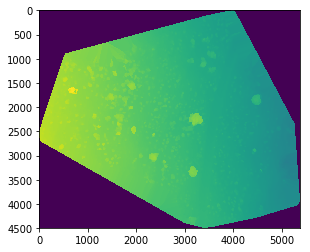

In [49]:
dsm = gdal.Open(geotif_dsm_file)
dsm = dsm.GetRasterBand(1).ReadAsArray()
plt.imshow(dsm, vmin=1600)

In [38]:
band_num = 1
srcband = gtif.GetRasterBand(band_num)


print("[ NO DATA VALUE ] = ", srcband.GetNoDataValue())
print("[ MIN ] = ", srcband.GetMinimum())
print("[ MAX ] = ", srcband.GetMaximum())
print ("[ SCALE ] = ", srcband.GetScale())
print( "[ UNIT TYPE ] = ", srcband.GetUnitType())

[ NO DATA VALUE ] =  -10000.0
[ MIN ] =  0.0
[ MAX ] =  255.0
[ SCALE ] =  1.0
[ UNIT TYPE ] =  


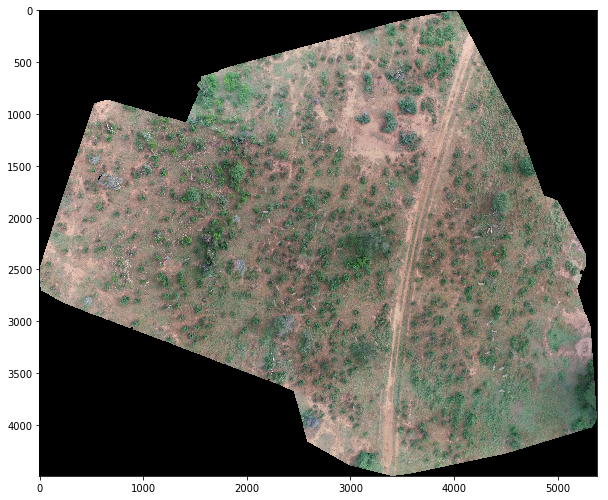

In [39]:
bands = []
for band_num in range(1, 4):
    srcband = gtif.GetRasterBand(band_num)
    a = srcband.ReadAsArray()
    bands.append(a)
image = np.stack(bands, 2)
image.shape
plt.figure(figsize=(10,10))
plt.imshow(image)

In [7]:
for band in range( gtif.RasterCount ):
    band += 1
    print ("[ GETTING BAND ]: ", band)
    srcband = gtif.GetRasterBand(band)
    if srcband is None:
        continue

    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue

    print ("[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                stats[0], stats[1], stats[2], stats[3] ))

[ GETTING BAND ]:  1
[ STATS ] =  Minimum=0.000, Maximum=255.000, Mean=85.968, StdDev=69.747
[ GETTING BAND ]:  2
[ STATS ] =  Minimum=0.000, Maximum=251.000, Mean=83.733, StdDev=64.726
[ GETTING BAND ]:  3
[ STATS ] =  Minimum=0.000, Maximum=250.000, Mean=74.037, StdDev=58.280
[ GETTING BAND ]:  4
[ STATS ] =  Minimum=0.000, Maximum=255.000, Mean=165.470, StdDev=121.715


In [11]:
scanline = srcband.ReadRaster(xoff=0, yoff=0,
                           xsize=srcband.XSize, ysize=srcband.YSize,
                           buf_xsize=srcband.XSize, buf_ysize=srcband.YSize,
                           buf_type=gdal.GDT_Float32)

In [12]:
srcband.YSize


4492

In [13]:
import struct
import numpy as np


In [14]:
tuple_of_floats = struct.unpack('f' * srcband.XSize * srcband.YSize, scanline)
raster = np.array(tuple_of_floats)
raster = raster.reshape((srcband.YSize, srcband.XSize))
raster.shape

(4492, 5383)

In [15]:
raster.max()

255.0

In [16]:
raster.min()

0.0

In [17]:
import matplotlib.pyplot as plt

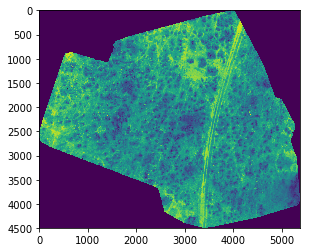

In [20]:
plt.imshow(raster)

In [15]:
transform = gtif.GetGeoTransform()

In [16]:
xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = transform[5]

267512.00274 37773.639240000004
2909 3488


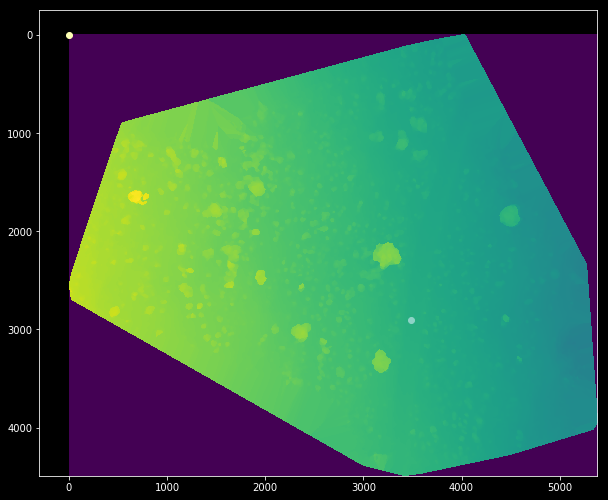

In [22]:
points_list = [(267613.14, 37689.28)] #list of X,Y coordinates
plt.style.use('dark_background')

plt.figure(figsize=(10,10))
plt.imshow(raster, vmin=1600)
print(xOrigin, yOrigin)
for point in points_list:
    col = int((point[0] - xOrigin) / pixelWidth)
    row = int((yOrigin - point[1] ) / -pixelHeight)
    print(row,col)
    plt.scatter(col, row)
plt.scatter(0,0)

In [26]:
image_locations_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/observation088/map_images/pix4d-output/observation088_calibrated_external_camera_parameters_wgs84.txt'

In [46]:
import pandas as pd
with open(image_locations_file, 'r') as f:
    data = f.readlines()
camera_info_names = data[0].split(' ')
camera_locations = pd.DataFrame(columns=camera_info_names)    
for line in data[1:]:
    camera_info = line.split(' ')
    camera_dict = {}
    for info_ind in range(len(camera_info)):
        if info_ind == 0:
            camera_dict[camera_info_names[info_ind]] = camera_info[info_ind]
        else:
            camera_dict[camera_info_names[info_ind]] = float(camera_info[info_ind])
    camera_locations = camera_locations.append(camera_dict, ignore_index=True)

In [57]:
lat_long = camera_locations[['latitude', 'longitude']]
lat_long

,latitude,longitude
0,0.341001,36.911570
1,0.340917,36.911901
2,0.340964,36.911916
3,0.340958,36.911594
4,0.340942,36.911642
5,0.340924,36.911690
6,0.340907,36.911737
7,0.340891,36.911786
8,0.340874,36.911834
9,0.340868,36.911881


267512.00274 37773.639240000004


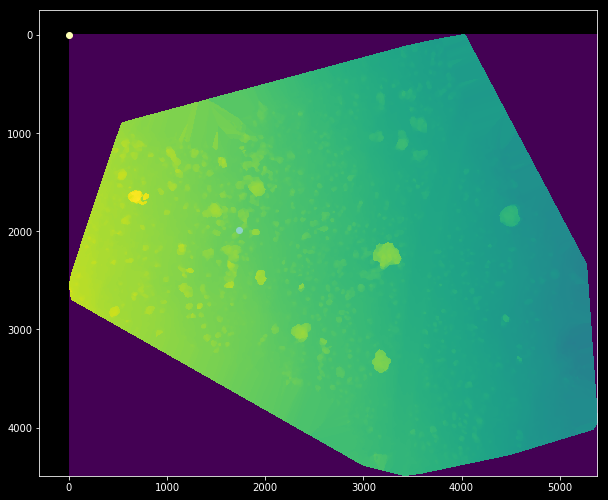

In [60]:
import utm
plt.style.use('dark_background')

plt.figure(figsize=(10,10))
plt.imshow(raster, vmin=1600)
print(xOrigin, yOrigin)
for point_ind in range(lat_long.shape[0])[:1]:
    x, y, t, v = utm.from_latlon(*lat_long.loc[point_ind].as_matrix())
    col = int((x - xOrigin) / pixelWidth)
    row = int((yOrigin - y) / -pixelHeight)
#     print(row,col)
    plt.scatter(col, row)
plt.scatter(0,0)

In [45]:
lat_long.loc[0, 'longitude']

'36.91157028'

In [ ]:
lat